Reference DSHIP data to AEW tracks

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import cftime

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers. Use 3956 for miles.
    r = 6371
    
    # Calculate the result
    return c * r

In [4]:
#Open the file with the AEW tracks from August-September 2024
#ds = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/code/AEWtracking/AEW_tracks_BOWTIE_post_processed.nc',decode_times=False)
AEW = xr.open_dataset('../AEWtracking/AEW_tracks_BOWTIE_post_processed.nc')

AEW_lon2024 = AEW.AEW_lon_smooth  # System x Time
AEW_lat2024 = AEW.AEW_lat_smooth  # System x Time
AEWtime = AEW.time  #
#time2024 = ds['time'].values  # Time in seconds since 1970-01-01 00:00:00.0
#start_date2024 = cftime.DatetimeGregorian(1970, 1, 1, 0, 0, 0)  # Use cftime for high capacity date handling

In [5]:
AEW

<xarray.Dataset> Size: 543kB
Dimensions:         (latitude: 61, longitude: 151, time: 244, system: 25)
Coordinates:
  * latitude        (latitude) float64 488B 49.62 48.62 47.62 ... -9.375 -10.0
  * longitude       (longitude) float64 1kB -89.62 -88.62 -87.62 ... 59.38 60.0
  * time            (time) datetime64[ns] 2kB 2024-08-01 ... 2024-09-30T18:00:00
  * system          (system) float64 200B 1.0 2.0 3.0 4.0 ... 23.0 24.0 25.0
Data variables:
    AEW_lon         (system, time) float64 49kB ...
    AEW_lat         (system, time) float64 49kB ...
    AEW_lon_smooth  (system, time) float64 49kB ...
    AEW_lat_smooth  (system, time) float64 49kB ...
    AEW_strength    (system, time) float64 49kB ...
    TC_gen_time     (system) datetime64[ns] 200B ...
    TC_name         (system) <U3 300B ...
    curv_data_mean  (time, longitude) float64 295kB ...

In [5]:
DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')

In [6]:
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
Data variables: (12/39)
    sst_port          (time) float64 472kB ...
    sst_extern_port   (time) float64 472kB ...
    sst_intern_port   (time) float64 472kB ...
    sst_board         (time) float64 472kB ...
    sst_extern_board  (time) float64 472kB ...
    sst_intern_board  (time) float64 472kB ...
    ...                ...
    ship_heave        (time) float64 472kB ...
    ship_heave_std    (time) float64 472kB ...
    ship_pitch        (time) float64 472kB ...
    ship_pitch_std    (time) float64 472kB ...
    ship_roll         (time) float64 472kB ...
    ship_roll_std     (time) float64 472kB ...

In [8]:
#Calculate distance to AEW along ship track

#initialize arrays  
dist_AEW_lon = np.full(len(DSHIP.time), np.nan)
min_dist_AEW = np.full(len(DSHIP.time), np.nan)

#extract ship position and time
ship_lat = DSHIP.lat
ship_lon = DSHIP.lon
ship_time = DSHIP.time

#Loop over ship track
for i in range(0,len(ship_time)):
    #Find the closest AEW time to the ship track time
    itime = np.abs(AEWtime - ship_time[i]).argmin()

    #Find the closest AEW in longitude at that time
    ilon = np.abs(AEW_lon2024[:,itime] - ship_lon[i]).argmin()

    #Find the distance in longitude  (use haversine at the ships latitude)
    dist_AEW_lon[i] = haversine(ship_lat[i],ship_lon[i],ship_lat[i],AEW_lon2024[ilon,itime]) #Distance in km

    #Compute the distance between the ship and all AEWs at that time
    dist_AEW = haversine(
        np.full(AEW_lat2024[:, itime].shape, ship_lat[i]),  # Ship latitude
        np.full(AEW_lon2024[:, itime].shape, ship_lon[i]),  # Ship longitude
        AEW_lat2024[:, itime],  # All AEW latitudes at closest time
        AEW_lon2024[:, itime]   # All AEW longitudes at closest time
    )

    #Store minimum distance
    min_dist_AEW[i] = np.nanmin(dist_AEW)

In [9]:
# Create a new xarray Dataset
ds = xr.Dataset(
    {
        "min_dist_AEW": (["time"], min_dist_AEW),
        "dist_AEW_lon": (["time"], dist_AEW_lon)
    },
    coords={
        "time": ship_time
    }
)

ds['min_dist_AEW'].attrs['units'] = 'km'
ds['dist_AEW_lon'].attrs['units'] = 'km'

ds['min_dist_AEW'].attrs['long_name'] = 'Minimum distance to AEW'
ds['dist_AEW_lon'].attrs['long_name'] = 'Distance to AEW in longitude'

# Save to NetCDF file
ds.to_netcdf("distances_to_AEW.nc")

In [10]:
# Find the index where ship time is 07:00 UTC on August 16
target_time = np.datetime64('2024-08-16T07:00:00')
index_start = np.where(ship_time == target_time)[0]
index_start = int(index_start[0])

target_time = np.datetime64('2024-09-02T00:00:00')
i1 = np.where(ship_time == target_time)[0]
i1 = int(i1[0])

target_time = np.datetime64('2024-09-06T06:00:00')
i2= np.where(ship_time == target_time)[0]
i2 = int(i2[0])

Text(0, 0.5, 'Distance (km)')

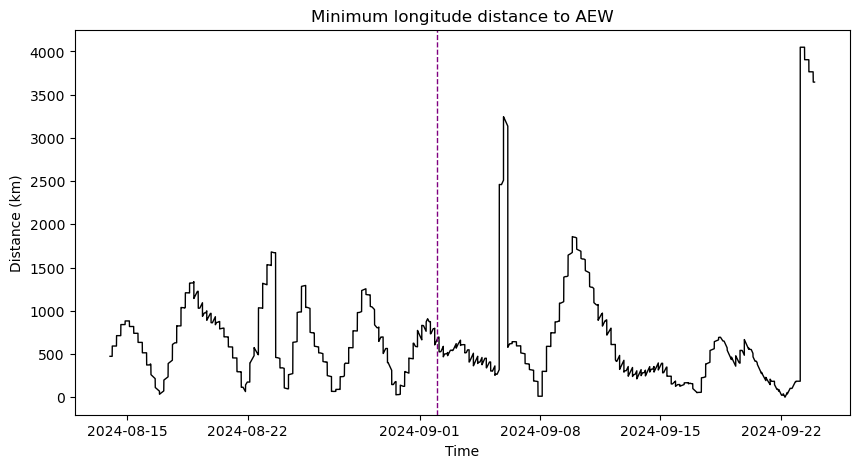

In [11]:
plt.figure(figsize=(10,5))
plt.plot(ship_time, dist_AEW_lon,'k',linewidth=1)
plt.axvline(pd.to_datetime(ship_time)[i1], color='purple', linestyle='--', linewidth=1)
plt.title('Minimum longitude distance to AEW')
plt.xlabel('Time')
plt.ylabel('Distance (km)')

Text(0, 0.5, 'Distance (km)')

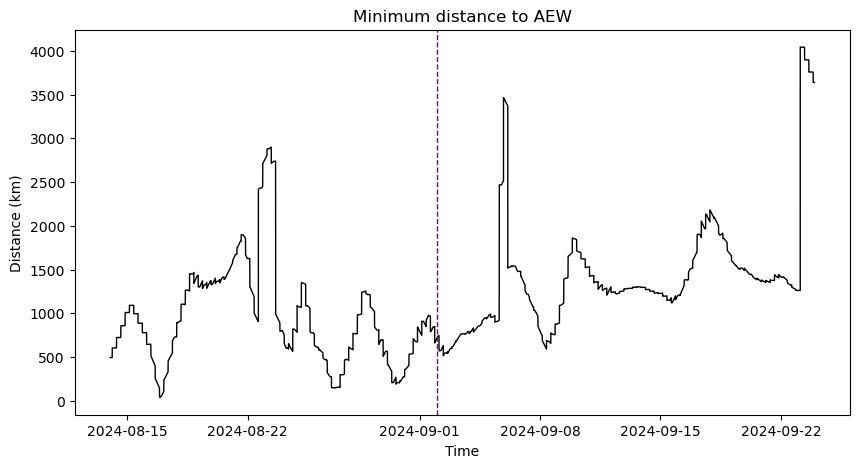

In [12]:
plt.figure(figsize=(10,5))
plt.plot(ship_time,min_dist_AEW,'k',linewidth=1)
plt.axvline(pd.to_datetime(ship_time)[i1], color='purple', linestyle='--', linewidth=1)
plt.title('Minimum distance to AEW')
plt.xlabel('Time')  
plt.ylabel('Distance (km)')

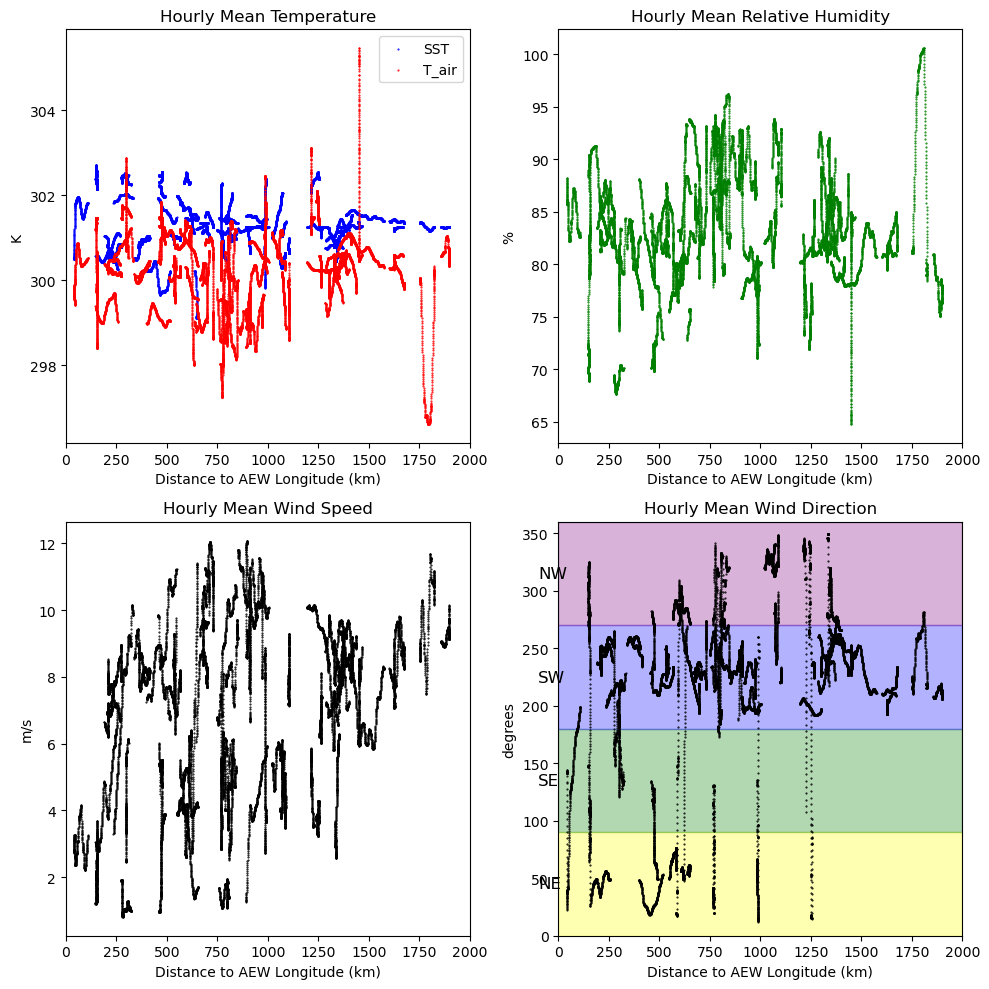

In [13]:
#scatter plot of stuff against longitude distance to AEW
nsmooth = 60 #60 for hourly running mean

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].scatter(min_dist_AEW[index_start:i1],DSHIP.sst_port[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="SST",color='b',marker='.',s=1)
axs[0,0].scatter(min_dist_AEW[index_start:i1],DSHIP.t_air_port[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="T_air",color='r',marker='.',s=1)
axs[0,0].legend()
axs[0,0].set_xlabel("Distance to AEW Longitude (km)")
axs[0,0].set_ylabel("K")
axs[0,0].set_title("Hourly Mean Temperature")
axs[0,0].set_xlim(0, 2000)

axs[0,1].scatter(min_dist_AEW[index_start:i1],DSHIP.rh_port[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="RH",color='g',marker='.',s=1)
axs[0,1].set_xlabel("Distance to AEW Longitude (km)")
axs[0,1].set_ylabel("%")
axs[0,1].set_title("Hourly Mean Relative Humidity")
axs[0,1].set_xlim(0, 2000)

axs[1,0].scatter(min_dist_AEW[index_start:i1],DSHIP.wspd[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="Wind Speed",color='k',marker='.',s=1)
axs[1,0].set_xlabel("Distance to AEW Longitude (km)")
axs[1,0].set_ylabel("m/s")
axs[1,0].set_title("Hourly Mean Wind Speed")
axs[1,0].set_xlim(0, 2000)

# Apply shading for the specified wind direction range

axs[1,1].axhspan(0, 90, color='yellow', alpha=0.3)
axs[1,1].text(-100, (0 + 90) / 2, 'NE', color='black', fontsize=12, verticalalignment='center')
axs[1,1].axhspan(90, 180, color='green', alpha=0.3)
axs[1,1].text(-100, (90 + 180) / 2, 'SE', color='black', fontsize=12, verticalalignment='center')
axs[1,1].axhspan(180, 270, color='blue', alpha=0.3)
axs[1,1].text(-100, (180 + 270) / 2, 'SW', color='black', fontsize=12, verticalalignment='center')
axs[1,1].axhspan(270, 360, color='purple', alpha=0.3)
axs[1,1].text(-100, (270 + 360) / 2, 'NW', color='black', fontsize=12, verticalalignment='center')

axs[1,1].scatter(min_dist_AEW[index_start:i1],DSHIP.wdir[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="Wind Direction",color='k',marker='.',s=1)
axs[1,1].set_xlabel("Distance to AEW Longitude (km)")
axs[1,1].set_ylabel("degrees")
axs[1,1].set_title("Hourly Mean Wind Direction")
axs[1,1].set_ylim(0, 360)
axs[1,1].set_xlim(0, 2000)

plt.tight_layout()  # Adjust subplots to fit into figure area.


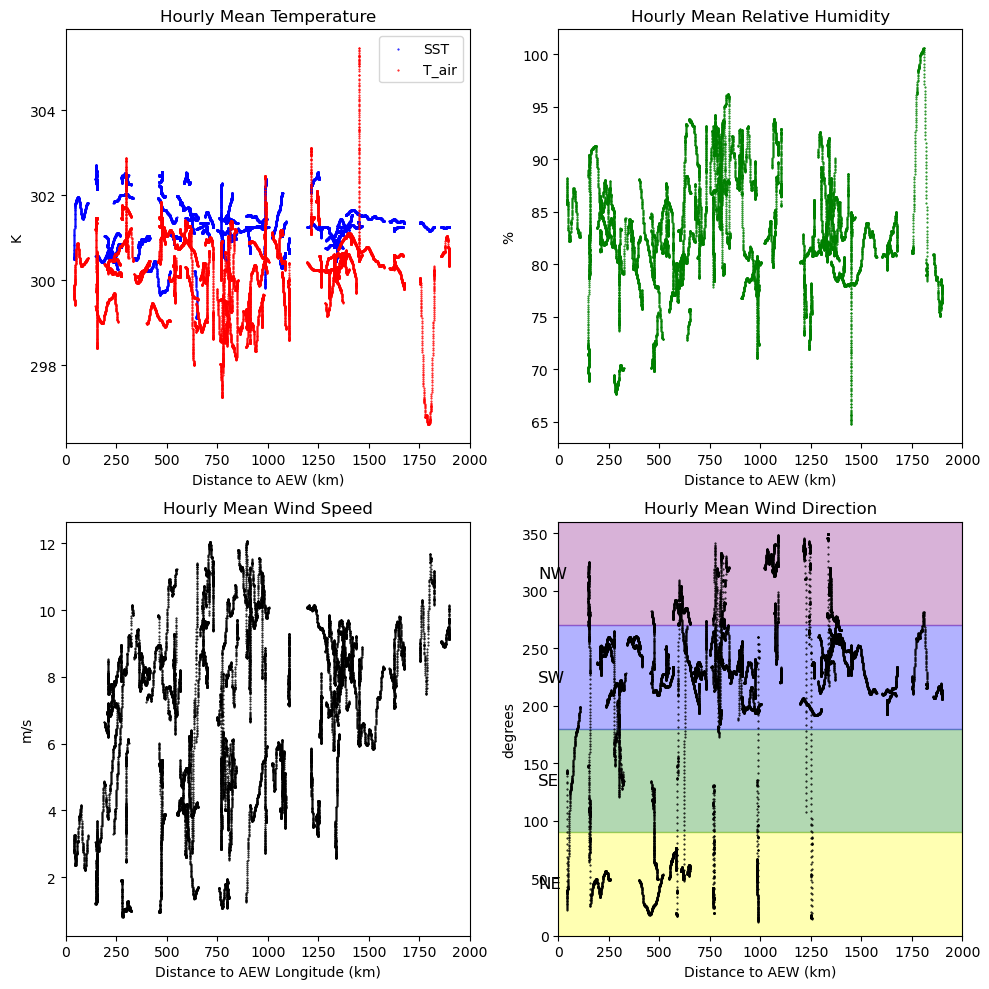

In [14]:
#scatter plot of stuff against distance to AEW
nsmooth = 60 #60 for hourly running mean

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].scatter(min_dist_AEW[index_start:i1],DSHIP.sst_port[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="SST",color='b',marker='.',s=1)
axs[0,0].scatter(min_dist_AEW[index_start:i1],DSHIP.t_air_port[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="T_air",color='r',marker='.',s=1)
axs[0,0].legend()
axs[0,0].set_xlabel("Distance to AEW (km)")
axs[0,0].set_ylabel("K")
axs[0,0].set_title("Hourly Mean Temperature")
axs[0,0].set_xlim(0, 2000)

axs[0,1].scatter(min_dist_AEW[index_start:i1],DSHIP.rh_port[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="RH",color='g',marker='.',s=1)
axs[0,1].set_xlabel("Distance to AEW (km)")
axs[0,1].set_ylabel("%")
axs[0,1].set_title("Hourly Mean Relative Humidity")
axs[0,1].set_xlim(0, 2000)

axs[1,0].scatter(min_dist_AEW[index_start:i1],DSHIP.wspd[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="Wind Speed",color='k',marker='.',s=1)
axs[1,0].set_xlabel("Distance to AEW Longitude (km)")
axs[1,0].set_ylabel("m/s")
axs[1,0].set_title("Hourly Mean Wind Speed")
axs[1,0].set_xlim(0, 2000)

# Apply shading for the specified wind direction range

axs[1,1].axhspan(0, 90, color='yellow', alpha=0.3)
axs[1,1].text(-100, (0 + 90) / 2, 'NE', color='black', fontsize=12, verticalalignment='center')
axs[1,1].axhspan(90, 180, color='green', alpha=0.3)
axs[1,1].text(-100, (90 + 180) / 2, 'SE', color='black', fontsize=12, verticalalignment='center')
axs[1,1].axhspan(180, 270, color='blue', alpha=0.3)
axs[1,1].text(-100, (180 + 270) / 2, 'SW', color='black', fontsize=12, verticalalignment='center')
axs[1,1].axhspan(270, 360, color='purple', alpha=0.3)
axs[1,1].text(-100, (270 + 360) / 2, 'NW', color='black', fontsize=12, verticalalignment='center')

axs[1,1].scatter(min_dist_AEW[index_start:i1],DSHIP.wdir[index_start:i1].rolling(time=nsmooth,center=True).mean(),label="Wind Direction",color='k',marker='.',s=1)
axs[1,1].set_xlabel("Distance to AEW (km)")
axs[1,1].set_ylabel("degrees")
axs[1,1].set_title("Hourly Mean Wind Direction")
axs[1,1].set_ylim(0, 360)
axs[1,1].set_xlim(0, 2000)

plt.tight_layout()  # Adjust subplots to fit into figure area.
